In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
import os
import warnings
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, silhouette_score, davies_bouldin_score, f1_score, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from enum import Enum
from kneed import KneeLocator
warnings.filterwarnings("ignore")

In [2]:
song_data = pd.read_csv('datasets/merged_spotify_dataset.csv')
song_data.info()
song_data.describe()
spotify_song_data = song_data.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058371 entries, 0 to 1058370
Data columns (total 27 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   Rank                              1058371 non-null  int64  
 1   Title                             1058371 non-null  object 
 2   Artists                           1058371 non-null  object 
 3   Date                              1058371 non-null  object 
 4   Danceability                      1058371 non-null  float64
 5   Energy                            1058371 non-null  float64
 6   Loudness                          1058371 non-null  float64
 7   Speechiness                       1058371 non-null  float64
 8   Acousticness                      1058371 non-null  float64
 9   Instrumentalness                  1058371 non-null  float64
 10  Valence                           1058371 non-null  float64
 11  # of Artist                       105

In [3]:
spotify_song_data['Date'] = pd.to_datetime(spotify_song_data['Date'], format='%d/%m/%Y')

spotify_song_data['Data_Month'] = spotify_song_data['Date'].dt.to_period('M')

spotify_song_data.head()

average_monthly_points = spotify_song_data.groupby(['id', 'Data_Month'])['Points (Total)'].mean().reset_index()

average_monthly_points.rename(columns={'Points (Total)': 'Average_Points'}, inplace=True)

monthly_data = pd.merge(spotify_song_data, average_monthly_points, on=['id', 'Data_Month'], how='left')

columns_to_drop = ['Points (Total)', 'Points (Ind for each Artist/Nat)', 'Date', 'Rank']
monthly_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

monthly_data.drop_duplicates(inplace=True)
monthly_unique_songs = monthly_data.drop_duplicates(subset=['id', 'Data_Month'])

monthly_unique_songs = monthly_unique_songs.dropna(subset=monthly_unique_songs.columns.difference(['genres']))

monthly_unique_songs.head(500)

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,...,Song URL,genres,popularity,key,liveness,mode,tempo,time_signature,Data_Month,Average_Points
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,...,https://open.spotify.com/track/3qQbCzHBycnDpGs...,"sierreno,sad sierreno,corridos tumbados,corrido",86.0,5.0,0.0837,0.0,147.989,3.0,2023-05,199.586207
4,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,...,https://open.spotify.com/track/7ro0hRteUMfnOio...,"urbano latino,reggaeton,trap latino",91.0,9.0,0.1120,0.0,143.978,4.0,2023-05,198.909091
5,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,...,https://open.spotify.com/track/2UW7JaomAMuX9pZ...,"reggaeton,sad sierreno,corridos tumbados",92.0,2.0,0.0756,0.0,169.922,4.0,2023-05,197.724138
7,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Artist 1,...,https://open.spotify.com/track/7FbrGaHYVDmfr7K...,k-pop girl group,88.0,11.0,0.3470,0.0,120.018,4.0,2023-05,196.689655
9,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Artist 1,...,https://open.spotify.com/track/6pD0ufEQq0xdHSs...,"reggaeton,musica chihuahuense,trap latino,urba...",89.0,6.0,0.2700,0.0,83.118,4.0,2023-05,198.793103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14195,REMIX EXCLUSIVO,Feid,0.651,0.557,-5466.0,0.204,0.036,0.000,0.711,Artist 1,...,https://open.spotify.com/track/3eqCJfgJJs8iKx4...,"pop reggaeton,reggaeton colombiano,colombian p...",78.0,5.0,0.1540,0.0,87.063,4.0,2023-04,76.846154
14199,Rolling in the Deep,Adele,0.730,0.769,-5114.0,0.030,0.138,0.000,0.507,Artist 1,...,https://open.spotify.com/track/6IAZHEBUIGJ6NJK...,"pop,uk pop,british soul,pop soul",48.0,8.0,0.0473,1.0,104.948,4.0,2023-04,3.333333
14204,Save Your Tears (Remix) (with Ariana Grande),"The Weeknd, Ariana Grande",0.650,0.825,-4645.0,0.033,0.022,0.000,0.593,Artist 1,...,https://open.spotify.com/track/1oFAF1hdPOickyH...,"pop,canadian contemporary r&b,canadian pop",83.0,0.0,0.0936,1.0,118.091,4.0,2023-04,35.375000
14321,Wish You The Best,Lewis Capaldi,0.678,0.480,-3607.0,0.030,0.588,0.000,0.490,Artist 1,...,https://open.spotify.com/track/3W5KHP0Yr56ejVD...,"pop,uk pop",83.0,3.0,0.0951,1.0,107.950,4.0,2023-04,65.500000


In [4]:
artist_average_points = monthly_unique_songs.groupby('Artists')['Average_Points'].mean()

monthly_unique_songs['Artist_Average_Points'] = monthly_unique_songs['Artists'].map(artist_average_points)

monthly_unique_songs.head()

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,# of Artist,...,genres,popularity,key,liveness,mode,tempo,time_signature,Data_Month,Average_Points,Artist_Average_Points
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Artist 1,...,"sierreno,sad sierreno,corridos tumbados,corrido",86.0,5.0,0.0837,0.0,147.989,3.0,2023-05,199.586207,197.178033
4,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Artist 1,...,"urbano latino,reggaeton,trap latino",91.0,9.0,0.1120,0.0,143.978,4.0,2023-05,198.909091,109.037847
5,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Artist 1,...,"reggaeton,sad sierreno,corridos tumbados",92.0,2.0,0.0756,0.0,169.922,4.0,2023-05,197.724138,183.266776
7,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Artist 1,...,k-pop girl group,88.0,11.0,0.3470,0.0,120.018,4.0,2023-05,196.689655,120.302751
9,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Artist 1,...,"reggaeton,musica chihuahuense,trap latino,urba...",89.0,6.0,0.2700,0.0,83.118,4.0,2023-05,198.793103,199.182266


In [5]:
# Define the main genres for categorization
main_genres = ['pop', 'rock', 'hip hop', 'rap', 'r&b', 'country', 'jazz', 'classical', 'electronic', 'dance', 'latin', 'reggae', 'blues', 'soul', 'funk', 'metal', 'punk', 'folk', 'world', 'indie', 'corrido']

def categorize_genre(sub_genres):
    sub_genres_list = str(sub_genres).lower().split(',')
    for main_genre in main_genres:
        if any(main_genre in sub_genre for sub_genre in sub_genres_list):
            return main_genre
    return 'other'

monthly_unique_songs['General_Genre'] = monthly_unique_songs['genres'].apply(categorize_genre)

columns_to_drop = ['# of Artist', 'Artist (Ind.)', '# of Nationality', 'Nationality', 
                   'Points (Ind for each Artist/Nat)', 'Points (Total)', 'Song URL', 'genres']

monthly_unique_songs = monthly_unique_songs.drop(columns=columns_to_drop, errors='ignore')

monthly_unique_songs.head(500)

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Continent,...,popularity,key,liveness,mode,tempo,time_signature,Data_Month,Average_Points,Artist_Average_Points,General_Genre
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Latin-America,...,86.0,5.0,0.0837,0.0,147.989,3.0,2023-05,199.586207,197.178033,corrido
4,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Latin-America,...,91.0,9.0,0.1120,0.0,143.978,4.0,2023-05,198.909091,109.037847,rap
5,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Latin-America,...,92.0,2.0,0.0756,0.0,169.922,4.0,2023-05,197.724138,183.266776,reggae
7,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Asia,...,88.0,11.0,0.3470,0.0,120.018,4.0,2023-05,196.689655,120.302751,pop
9,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Latin-America,...,89.0,6.0,0.2700,0.0,83.118,4.0,2023-05,198.793103,199.182266,rap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14195,REMIX EXCLUSIVO,Feid,0.651,0.557,-5466.0,0.204,0.036,0.000,0.711,Latin-America,...,78.0,5.0,0.1540,0.0,87.063,4.0,2023-04,76.846154,83.096973,pop
14199,Rolling in the Deep,Adele,0.730,0.769,-5114.0,0.030,0.138,0.000,0.507,Europe,...,48.0,8.0,0.0473,1.0,104.948,4.0,2023-04,3.333333,84.822089,pop
14204,Save Your Tears (Remix) (with Ariana Grande),"The Weeknd, Ariana Grande",0.650,0.825,-4645.0,0.033,0.022,0.000,0.593,Anglo-America,...,83.0,0.0,0.0936,1.0,118.091,4.0,2023-04,35.375000,127.497888,pop
14321,Wish You The Best,Lewis Capaldi,0.678,0.480,-3607.0,0.030,0.588,0.000,0.490,Europe,...,83.0,3.0,0.0951,1.0,107.950,4.0,2023-04,65.500000,109.174403,pop


In [6]:
# Calculating the mean popularity
mean_popularity = monthly_unique_songs['popularity'].mean()

monthly_unique_songs['is_popular'] = (monthly_unique_songs['popularity'] >= mean_popularity).astype(int)

In [7]:
from textblob import TextBlob

monthly_unique_songs['sentiment'] = monthly_unique_songs['Title'].map(lambda text: TextBlob(text).sentiment.polarity)

cut = pd.cut(
    monthly_unique_songs['sentiment'],
    [-np.inf, -.01, .01, np.inf],
    labels=['negative', 'neutral', 'positive']
)

monthly_unique_songs['polarity'] = cut.values

monthly_unique_songs[['polarity', 'sentiment']].head()

,polarity,sentiment
0,neutral,0.0
4,neutral,0.0
5,neutral,0.0
7,neutral,0.0
9,neutral,0.0


In [8]:
# Performing one-hot encoding for the specified columns
one_hot_continent = pd.get_dummies(monthly_unique_songs['Continent'], prefix='Continent')
one_hot_key = pd.get_dummies(monthly_unique_songs['key'], prefix='Key')
one_hot_mode = pd.get_dummies(monthly_unique_songs['mode'], prefix='Mode')
one_hot_time_signature = pd.get_dummies(monthly_unique_songs['time_signature'], prefix='Time_Signature')
one_hot_polarity = pd.get_dummies(monthly_unique_songs['polarity'], prefix='Polarity')
one_hot_genre = pd.get_dummies(monthly_unique_songs['General_Genre'], prefix='General_Genre')


# Concatenating the one-hot encoded columns with the original dataframe
monthly_unique_songs = pd.concat([monthly_unique_songs, one_hot_continent, one_hot_key, one_hot_mode, one_hot_time_signature, one_hot_polarity, one_hot_genre], axis=1)
monthly_unique_songs.head(500)

,Title,Artists,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Valence,Continent,...,General_Genre_latin,General_Genre_metal,General_Genre_other,General_Genre_pop,General_Genre_punk,General_Genre_r&b,General_Genre_rap,General_Genre_reggae,General_Genre_rock,General_Genre_soul
0,Ella Baila Sola,"Eslabon Armado, Peso Pluma",0.668,0.758,-5176.0,0.033,0.483,0.000,0.834,Latin-America,...,0,0,0,0,0,0,0,0,0,0
4,WHERE SHE GOES,Bad Bunny,0.652,0.800,-4019.0,0.061,0.143,0.629,0.234,Latin-America,...,0,0,0,0,0,0,1,0,0,0
5,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,-5678.0,0.333,0.213,0.000,0.559,Latin-America,...,0,0,0,0,0,0,0,1,0,0
7,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,-8332.0,0.033,0.435,0.000,0.726,Asia,...,0,0,0,1,0,0,0,0,0,0
9,un x100to,"Grupo Frontera, Bad Bunny",0.569,0.724,-4076.0,0.047,0.228,0.000,0.562,Latin-America,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14195,REMIX EXCLUSIVO,Feid,0.651,0.557,-5466.0,0.204,0.036,0.000,0.711,Latin-America,...,0,0,0,1,0,0,0,0,0,0
14199,Rolling in the Deep,Adele,0.730,0.769,-5114.0,0.030,0.138,0.000,0.507,Europe,...,0,0,0,1,0,0,0,0,0,0
14204,Save Your Tears (Remix) (with Ariana Grande),"The Weeknd, Ariana Grande",0.650,0.825,-4645.0,0.033,0.022,0.000,0.593,Anglo-America,...,0,0,0,1,0,0,0,0,0,0
14321,Wish You The Best,Lewis Capaldi,0.678,0.480,-3607.0,0.030,0.588,0.000,0.490,Europe,...,0,0,0,1,0,0,0,0,0,0


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Selecting the features for the model
feature_columns = ['Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 
                           'Instrumentalness', 'Valence', 'tempo'] + \
                  [col for col in monthly_unique_songs.columns if col.startswith('Key_')] + \
                  [col for col in monthly_unique_songs.columns if col.startswith('Continent_')] + \
                  [col for col in monthly_unique_songs.columns if col.startswith('Mode_')] + \
                  [col for col in monthly_unique_songs.columns if col.startswith('Time_Signature_')] + \
                  [col for col in monthly_unique_songs.columns if col.startswith('Polarity_')] + \
                  [col for col in monthly_unique_songs.columns if col.startswith('General_Genre_')]


target_column = 'is_popular'

X = monthly_unique_songs[feature_columns]
y = monthly_unique_songs[target_column]

X = X.fillna(X.mean())

# Splitting the data into training and testing sets (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19257, 8), (6419, 8), (19257,), (6419,))

In [17]:
from sklearn.metrics import confusion_matrix
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

accuracy, conf_matrix, class_report

(0.6600716622526873,
 array([[   1, 2182],
        [   0, 4236]]),
 '              precision    recall  f1-score   support\n\n           0       1.00      0.00      0.00      2183\n           1       0.66      1.00      0.80      4236\n\n    accuracy                           0.66      6419\n   macro avg       0.83      0.50      0.40      6419\nweighted avg       0.78      0.66      0.53      6419\n')

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

accuracy_rf, conf_matrix_rf, class_report_rf, roc_auc_rf

(0.9225736095965104,
 array([[1863,  320],
        [ 177, 4059]]),
 '              precision    recall  f1-score   support\n\n           0       0.91      0.85      0.88      2183\n           1       0.93      0.96      0.94      4236\n\n    accuracy                           0.92      6419\n   macro avg       0.92      0.91      0.91      6419\nweighted avg       0.92      0.92      0.92      6419\n',
 0.9858847900572585)

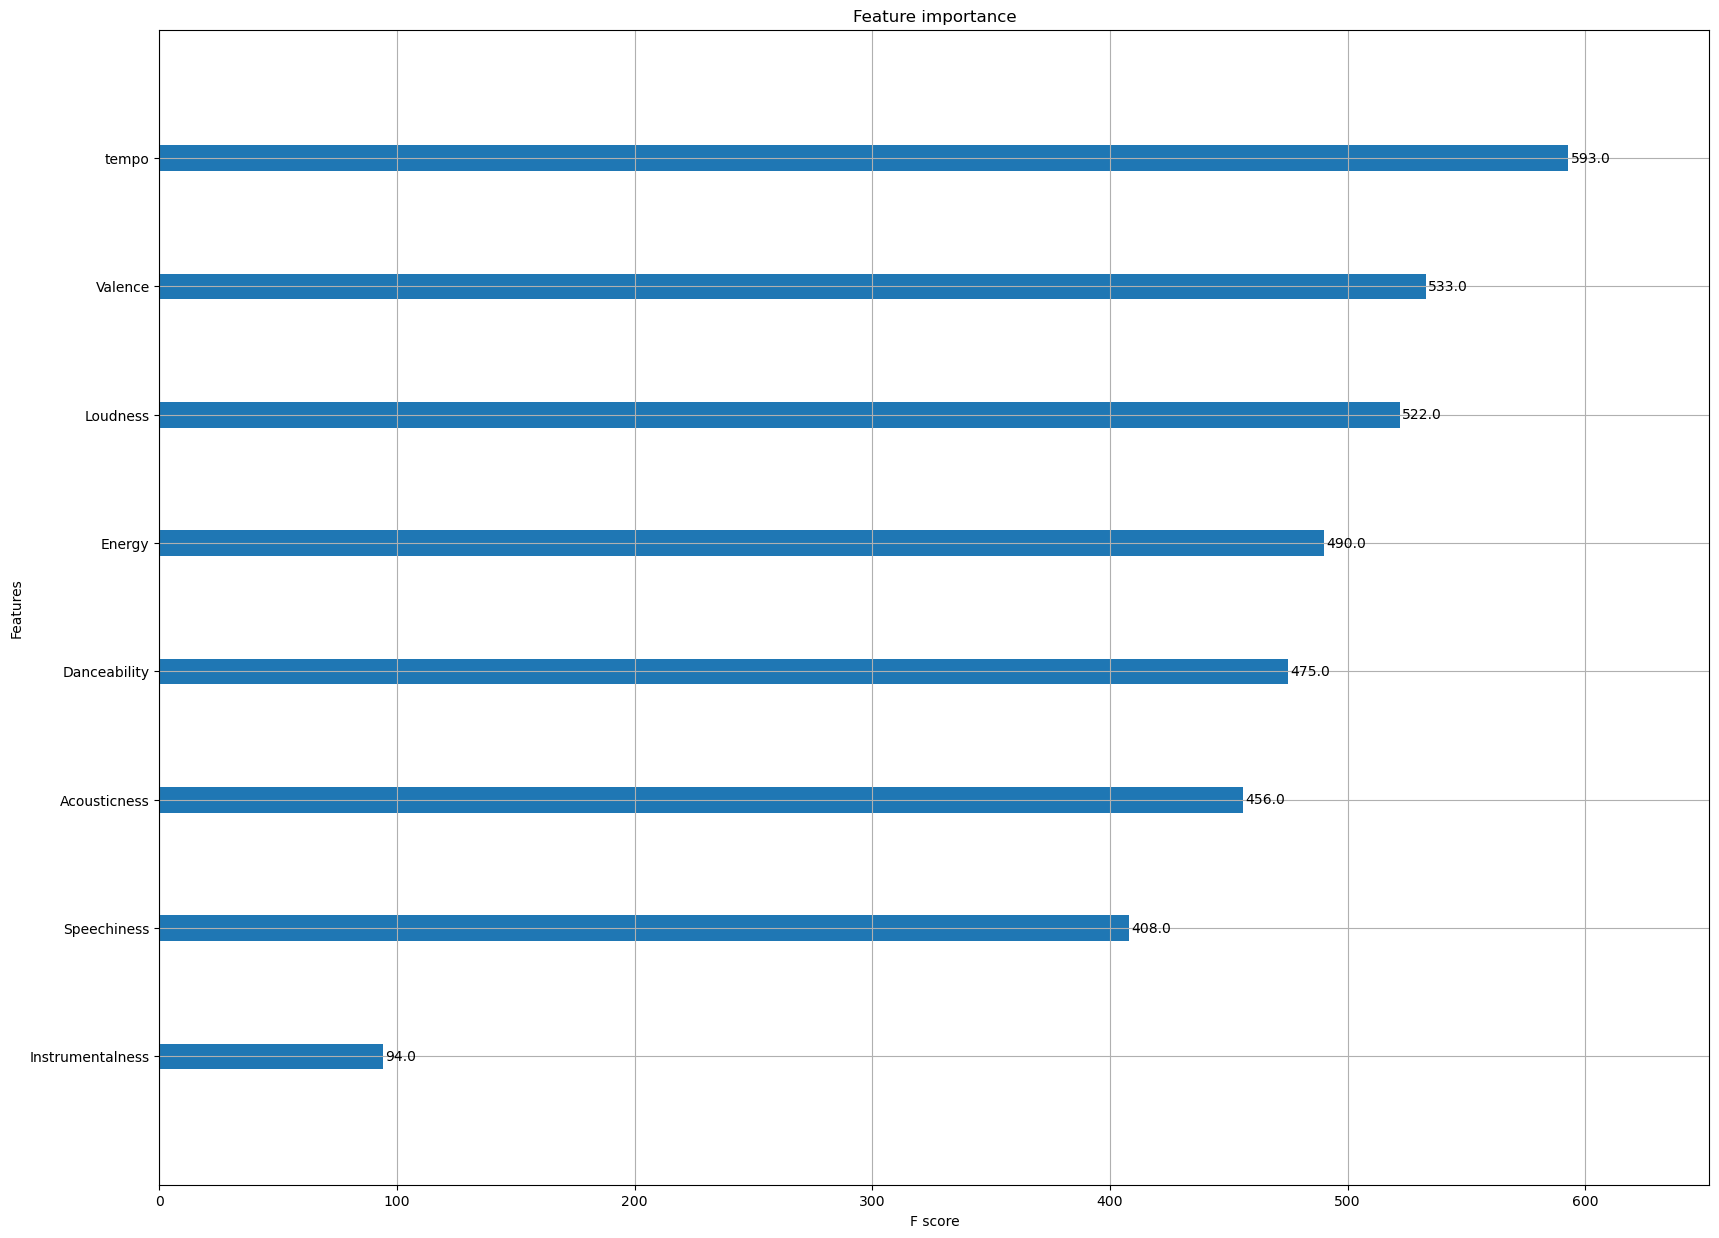

In [19]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

model = XGBClassifier()
model.fit(X_train, y_train)

# plot feature importance
ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(20, 15)
#plot_importance(model)
pyplot.show()

In [13]:
from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(random_state=42, max_iter=1000)

log_reg_model.fit(X_train, y_train)

y_pred_log_reg = log_reg_model.predict(X_test)

accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)

y_prob_log_reg = log_reg_model.predict_proba(X_test)[:, 1]
roc_auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)

accuracy_log_reg, conf_matrix_log_reg, class_report_log_reg, roc_auc_log_reg

(0.6689515500856831,
 array([[ 345, 1838],
        [ 287, 3949]]),
 '              precision    recall  f1-score   support\n\n           0       0.55      0.16      0.25      2183\n           1       0.68      0.93      0.79      4236\n\n    accuracy                           0.67      6419\n   macro avg       0.61      0.55      0.52      6419\nweighted avg       0.64      0.67      0.60      6419\n',
 0.636988401230731)

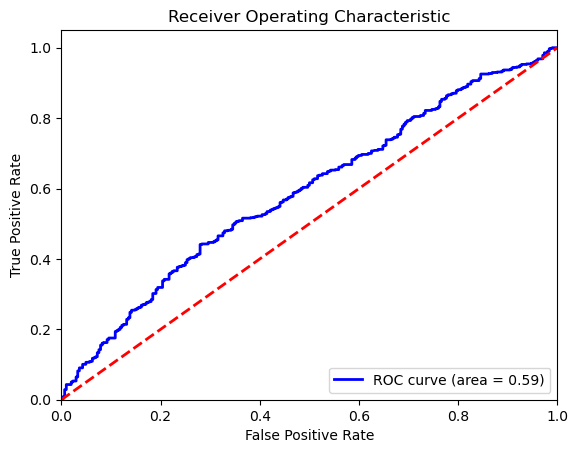

In [14]:
import matplotlib.pyplot as plt

log_reg_model_simplified = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model_simplified.fit(X_train.iloc[:1000], y_train.iloc[:1000])  # Using a subset of the data

y_prob_simplified = log_reg_model_simplified.predict_proba(X_test.iloc[:1000])[:, 1]
fpr_simplified, tpr_simplified, thresholds_simplified = roc_curve(y_test.iloc[:1000], y_prob_simplified)
roc_auc_simplified = auc(fpr_simplified, tpr_simplified)

# Plotting the ROC Curve
plt.figure()
plt.plot(fpr_simplified, tpr_simplified, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_simplified)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()